In [1]:
%%html
<style>
    #notebook-container{
    width: 100%
    }
</style>

In [2]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stat

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import model_selection
from scipy import stats

sns.set()

In [3]:
# telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Statistic/master/telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2. The variable "tenure" is taken as the dependent variable and the remaining variables as explanatory. <br>

## Subtask 1.

The lasso regression is an alternative approach to variable selection. <br>

### Part (a)
Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

### Part (b)

For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \bar x)/\hat \sigma_x$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable "ed"?

For Lasso regression scaling of data become crucial because independent variables should be centered around 0 (have mean of 0). Because of this reason we perform scaling of data as per formula $\frac{(x_i - \bar x)}{\hat \sigma_x}$. Without scaling Lasso regression would provide a wrong results - countours of Least Square solution will intersect with non-scaled data in different points than it should. <br>

As for binary variables - those should be scaled as well. Otherwise for such variables like "gender" mean value will be around 0.5 and not 0 as it should be. Same holds for other binary variables - mean value is not equal to 0 as result Lasso regression will produce wrong results. Hence, I am also scaling all dummy variables to center those around mean of 0. <br>

For variable "ed", in addition to scaling, we also need to group all education related dummy variables and perform group Lasso regression which keeps related dummy variables as single group. In such case either none or all of such variables are excluded. Grouped dummy variables could not be excluded partially.

In [4]:
telco_df_norm = telco_df.copy() #normalizing data

telco_df_norm.tenure = (telco_df_norm.tenure-telco_df_norm.tenure.mean()) / telco_df_norm.tenure.std()
telco_df_norm.age = (telco_df_norm.age-telco_df_norm.age.mean()) / telco_df_norm.age.std()
telco_df_norm.address = (telco_df_norm.address-telco_df_norm.address.mean()) / telco_df_norm.address.std()
telco_df_norm.income = (telco_df_norm.income-telco_df_norm.income.mean()) / telco_df_norm.income.std()
telco_df_norm.employ = (telco_df_norm.employ-telco_df_norm.employ.mean()) / telco_df_norm.employ.std()
telco_df_norm.longmon = (telco_df_norm.longmon-telco_df_norm.longmon.mean()) / telco_df_norm.longmon.std()
telco_df_norm.wiremon = (telco_df_norm.wiremon-telco_df_norm.wiremon.mean()) / telco_df_norm.wiremon.std()

telco_df_norm.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00


In [5]:
telco_df_norm_dummy = telco_df_norm.copy()

telco_df_norm_dummy = pd.get_dummies(telco_df_norm, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))

telco_df_norm_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_norm_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_norm_dummy.marital_dummy = (telco_df_norm_dummy.marital_dummy-telco_df_norm_dummy.marital_dummy.mean()) / telco_df_norm_dummy.marital_dummy.std()
telco_df_norm_dummy.retire_dummy = (telco_df_norm_dummy.retire_dummy-telco_df_norm_dummy.retire_dummy.mean()) / telco_df_norm_dummy.retire_dummy.std()
telco_df_norm_dummy.gender_dummy = (telco_df_norm_dummy.gender_dummy-telco_df_norm_dummy.gender_dummy.mean()) / telco_df_norm_dummy.gender_dummy.std()
telco_df_norm_dummy.churn_dummy = (telco_df_norm_dummy.churn_dummy-telco_df_norm_dummy.churn_dummy.mean()) / telco_df_norm_dummy.churn_dummy.std()
telco_df_norm_dummy.ed_dummy_college_degree = (telco_df_norm_dummy.ed_dummy_college_degree-telco_df_norm_dummy.ed_dummy_college_degree.mean()) / telco_df_norm_dummy.ed_dummy_college_degree.std()
telco_df_norm_dummy.ed_dummy_no_high_school = (telco_df_norm_dummy.ed_dummy_no_high_school-telco_df_norm_dummy.ed_dummy_no_high_school.mean()) / telco_df_norm_dummy.ed_dummy_no_high_school.std()
telco_df_norm_dummy.ed_dummy_high_school = (telco_df_norm_dummy.ed_dummy_high_school-telco_df_norm_dummy.ed_dummy_high_school.mean()) / telco_df_norm_dummy.ed_dummy_high_school.std()
telco_df_norm_dummy.ed_dummy_some_college = (telco_df_norm_dummy.ed_dummy_some_college-telco_df_norm_dummy.ed_dummy_some_college.mean()) / telco_df_norm_dummy.ed_dummy_some_college.std()

telco_df_norm_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16,9.992007e-17,-1.318390e-16,-2.435829e-16,6.616929e-17,-8.992806e-17,-1.403322e-16,1.296740e-16,1.183498e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01,1.009545e+00,-2.219654e-01,1.034081e+00,1.626956e+00,-5.524288e-01,-5.059893e-01,1.575384e+00,-5.137687e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00,1.009545e+00,4.500702e+00,1.034081e+00,1.626956e+00,1.808378e+00,1.974350e+00,1.575384e+00,1.944455e+00


### Part (c)

Run a lasso regression for data with $\lambda \in (0, 1)$. Plot the estimated parameters as functions of $\lambda$. Which value of $\lambda$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

For alpha=0.80000
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79900
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79800
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79700
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79600
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79500
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79400
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79300
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79200
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79100
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79000
Training score: 0.00000
Test score: -0.02047
Number of feature

For alpha=0.70200
Training score: 0.04824
Test score: 0.02282
Number of features used: 1 

For alpha=0.70100
Training score: 0.04953
Test score: 0.02398
Number of features used: 1 

For alpha=0.70000
Training score: 0.05081
Test score: 0.02514
Number of features used: 1 

For alpha=0.69900
Training score: 0.05209
Test score: 0.02629
Number of features used: 1 

For alpha=0.69800
Training score: 0.05337
Test score: 0.02745
Number of features used: 1 

For alpha=0.69700
Training score: 0.05465
Test score: 0.02860
Number of features used: 1 

For alpha=0.69600
Training score: 0.05592
Test score: 0.02976
Number of features used: 1 

For alpha=0.69500
Training score: 0.05719
Test score: 0.03091
Number of features used: 1 

For alpha=0.69400
Training score: 0.05847
Test score: 0.03206
Number of features used: 1 

For alpha=0.69300
Training score: 0.05974
Test score: 0.03321
Number of features used: 1 

For alpha=0.69200
Training score: 0.06100
Test score: 0.03435
Number of features used: 1 


For alpha=0.60400
Training score: 0.16539
Test score: 0.13027
Number of features used: 1 

For alpha=0.60300
Training score: 0.16649
Test score: 0.13130
Number of features used: 1 

For alpha=0.60200
Training score: 0.16760
Test score: 0.13234
Number of features used: 1 

For alpha=0.60100
Training score: 0.16870
Test score: 0.13337
Number of features used: 1 

For alpha=0.60000
Training score: 0.16980
Test score: 0.13439
Number of features used: 1 

For alpha=0.59900
Training score: 0.17089
Test score: 0.13542
Number of features used: 1 

For alpha=0.59800
Training score: 0.17199
Test score: 0.13645
Number of features used: 1 

For alpha=0.59700
Training score: 0.17308
Test score: 0.13747
Number of features used: 1 

For alpha=0.59600
Training score: 0.17417
Test score: 0.13850
Number of features used: 1 

For alpha=0.59500
Training score: 0.17526
Test score: 0.13952
Number of features used: 1 

For alpha=0.59400
Training score: 0.17635
Test score: 0.14054
Number of features used: 1 


For alpha=0.49900
Training score: 0.27139
Test score: 0.23165
Number of features used: 1 

For alpha=0.49800
Training score: 0.27230
Test score: 0.23254
Number of features used: 1 

For alpha=0.49700
Training score: 0.27321
Test score: 0.23344
Number of features used: 1 

For alpha=0.49600
Training score: 0.27412
Test score: 0.23434
Number of features used: 1 

For alpha=0.49500
Training score: 0.27503
Test score: 0.23523
Number of features used: 1 

For alpha=0.49400
Training score: 0.27593
Test score: 0.23612
Number of features used: 1 

For alpha=0.49300
Training score: 0.27684
Test score: 0.23701
Number of features used: 1 

For alpha=0.49200
Training score: 0.27774
Test score: 0.23790
Number of features used: 1 

For alpha=0.49100
Training score: 0.27864
Test score: 0.23879
Number of features used: 1 

For alpha=0.49000
Training score: 0.27954
Test score: 0.23968
Number of features used: 1 

For alpha=0.48900
Training score: 0.28043
Test score: 0.24056
Number of features used: 1 


For alpha=0.38500
Training score: 0.36363
Test score: 0.32561
Number of features used: 1 

For alpha=0.38400
Training score: 0.36433
Test score: 0.32636
Number of features used: 1 

For alpha=0.38300
Training score: 0.36503
Test score: 0.32711
Number of features used: 1 

For alpha=0.38200
Training score: 0.36573
Test score: 0.32786
Number of features used: 1 

For alpha=0.38100
Training score: 0.36643
Test score: 0.32860
Number of features used: 1 

For alpha=0.38000
Training score: 0.36713
Test score: 0.32935
Number of features used: 1 

For alpha=0.37900
Training score: 0.36782
Test score: 0.33009
Number of features used: 1 

For alpha=0.37800
Training score: 0.36852
Test score: 0.33083
Number of features used: 1 

For alpha=0.37700
Training score: 0.36921
Test score: 0.33157
Number of features used: 1 

For alpha=0.37600
Training score: 0.36990
Test score: 0.33231
Number of features used: 1 

For alpha=0.37500
Training score: 0.37058
Test score: 0.33305
Number of features used: 1 


For alpha=0.27700
Training score: 0.45875
Test score: 0.42626
Number of features used: 4 

For alpha=0.27600
Training score: 0.45957
Test score: 0.42716
Number of features used: 4 

For alpha=0.27500
Training score: 0.46040
Test score: 0.42805
Number of features used: 4 

For alpha=0.27400
Training score: 0.46122
Test score: 0.42895
Number of features used: 4 

For alpha=0.27300
Training score: 0.46203
Test score: 0.42984
Number of features used: 4 

For alpha=0.27200
Training score: 0.46285
Test score: 0.43073
Number of features used: 4 

For alpha=0.27100
Training score: 0.46366
Test score: 0.43162
Number of features used: 4 

For alpha=0.27000
Training score: 0.46447
Test score: 0.43251
Number of features used: 4 

For alpha=0.26900
Training score: 0.46527
Test score: 0.43339
Number of features used: 4 

For alpha=0.26800
Training score: 0.46608
Test score: 0.43427
Number of features used: 4 

For alpha=0.26700
Training score: 0.46687
Test score: 0.43515
Number of features used: 4 


For alpha=0.16600
Training score: 0.53390
Test score: 0.51470
Number of features used: 5 

For alpha=0.16500
Training score: 0.53454
Test score: 0.51563
Number of features used: 5 

For alpha=0.16400
Training score: 0.53517
Test score: 0.51655
Number of features used: 5 

For alpha=0.16300
Training score: 0.53580
Test score: 0.51746
Number of features used: 5 

For alpha=0.16200
Training score: 0.53643
Test score: 0.51838
Number of features used: 5 

For alpha=0.16100
Training score: 0.53706
Test score: 0.51928
Number of features used: 5 

For alpha=0.16000
Training score: 0.53768
Test score: 0.52019
Number of features used: 5 

For alpha=0.15900
Training score: 0.53829
Test score: 0.52109
Number of features used: 5 

For alpha=0.15800
Training score: 0.53891
Test score: 0.52199
Number of features used: 5 

For alpha=0.15700
Training score: 0.53952
Test score: 0.52288
Number of features used: 5 

For alpha=0.15600
Training score: 0.54012
Test score: 0.52377
Number of features used: 5 


For alpha=0.05500
Training score: 0.59852
Test score: 0.59838
Number of features used: 8 

For alpha=0.05400
Training score: 0.59918
Test score: 0.59899
Number of features used: 8 

For alpha=0.05300
Training score: 0.59983
Test score: 0.59958
Number of features used: 8 

For alpha=0.05200
Training score: 0.60047
Test score: 0.60016
Number of features used: 8 

For alpha=0.05100
Training score: 0.60109
Test score: 0.60073
Number of features used: 8 

For alpha=0.05000
Training score: 0.60170
Test score: 0.60129
Number of features used: 8 

For alpha=0.04900
Training score: 0.60230
Test score: 0.60183
Number of features used: 8 

For alpha=0.04800
Training score: 0.60289
Test score: 0.60236
Number of features used: 8 

For alpha=0.04700
Training score: 0.60347
Test score: 0.60288
Number of features used: 8 

For alpha=0.04600
Training score: 0.60403
Test score: 0.60339
Number of features used: 8 

For alpha=0.04500
Training score: 0.60458
Test score: 0.60389
Number of features used: 8 


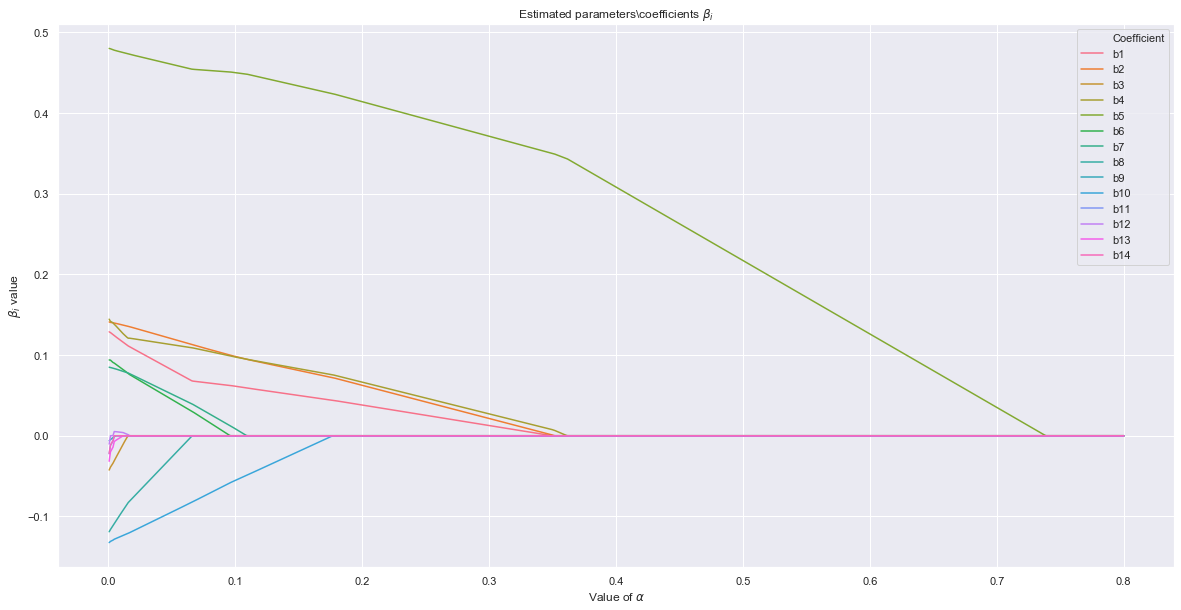

In [6]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

# lambdas = [0.9, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001]
lambdas = np.arange(0.8, 0, -0.001)
coefficients = []

for lambd in lambdas:
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y, test_size=0.3, random_state=7)

    lasso = linear_model.Lasso(alpha=lambd)
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    coefficients.append(lasso.coef_)

    print("For alpha=%.5f" %lambd)
    print("Training score: %.5f" %train_score )
    print("Test score: %.5f" %test_score)
    print("Number of features used: %s \n" %coeff_used)
    

coefficients_df = pd.DataFrame(coefficients, columns=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14"])
coefficients_df['alpha'] = lambdas
coefficients_df = coefficients_df.melt(id_vars=['alpha'], var_name='Coefficient')
coefficients_df.tail()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="alpha", y="value", hue="Coefficient", data=coefficients_df, )
# sns.lineplot(x=alphas, y="b2", data=coefficients_df)
# sns.lineplot(x=alphas, y="b3", data=coefficients_df)
plt.title("Estimated parameters\coefficients $\\beta_i$")
plt.ylabel("$\\beta_i$ value")
plt.xlabel("Value of $\\alpha$")
plt.show()

From this plot and printed test errors we could see that more or less accuracy of 61% achieved around $\lambda = 0.03$ so it make sense to recommend this value. Also with this values of $\lambda$ there is only 8 non-zero features coefficients and others are zeroed out. Now I would try to find optimal values of $\lambda$ by cross-validation.

In [7]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

lassoCV = linear_model.LassoCV(cv=15, random_state=7)
lassoCV.fit(X, Y)

print("Final score of CV: %.5f" %lassoCV.score(X, Y))
print("Optimal value of found by CV lambda = %.5f" %lassoCV.alpha_)
print("Optimal coefficients found by CV: %s" %lassoCV.coef_.round(5))

Final score of CV: 0.62021
Optimal value of found by CV lambda = 0.01162
Optimal coefficients found by CV: [ 0.09673  0.1427  -0.       0.11734  0.51164  0.05954  0.06464 -0.08162
 -0.0027  -0.1452  -0.00884  0.      -0.      -0.     ]


Optimal value of $\lambda$ found by Cross Validation is $\lambda=0.01162$.

## Subtask 2.

A nonlinear regression oﬀers a ﬂexible technique for modelling complex relationships. We wish to explain the "tenure" by the long distance calls per month "longmon". <br>

### Part (a)

Make a bivariate scatter plot and estimate an appropriate linear model. Add the regression line to the plot. 

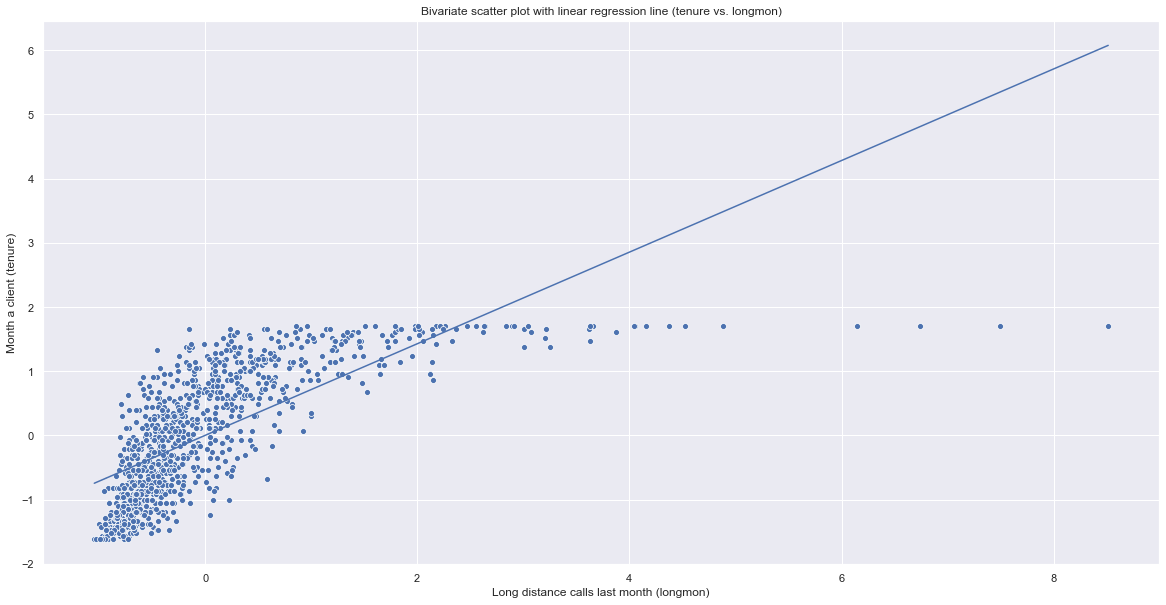

Adjusted R2 score of linear model: 0.50884
Root Mean Square Error (RMSE): 0.70012


In [77]:
X = telco_df_norm_dummy.copy().longmon
X = sm.add_constant(X)
Y = telco_df_norm_dummy.copy().tenure

result = sm.OLS(Y , X).fit()

Y_pred_man = np.dot(X, result.params)

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=Y_pred_man)
plt.title("Bivariate scatter plot with linear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - result.fittedvalues)**2).mean())
print("Adjusted R2 score of linear model: %.5f" %result.rsquared_adj)
print("Root Mean Square Error (RMSE) of linear model: %.5f" %rmse)

# result.summary()

### Part(b)

Estimate now an appropriate nonlinear regression which might ﬁt the data better. Add the regression curve to the plot and compare (quantitatively) the ﬁt with the ﬁt of the linear model. 

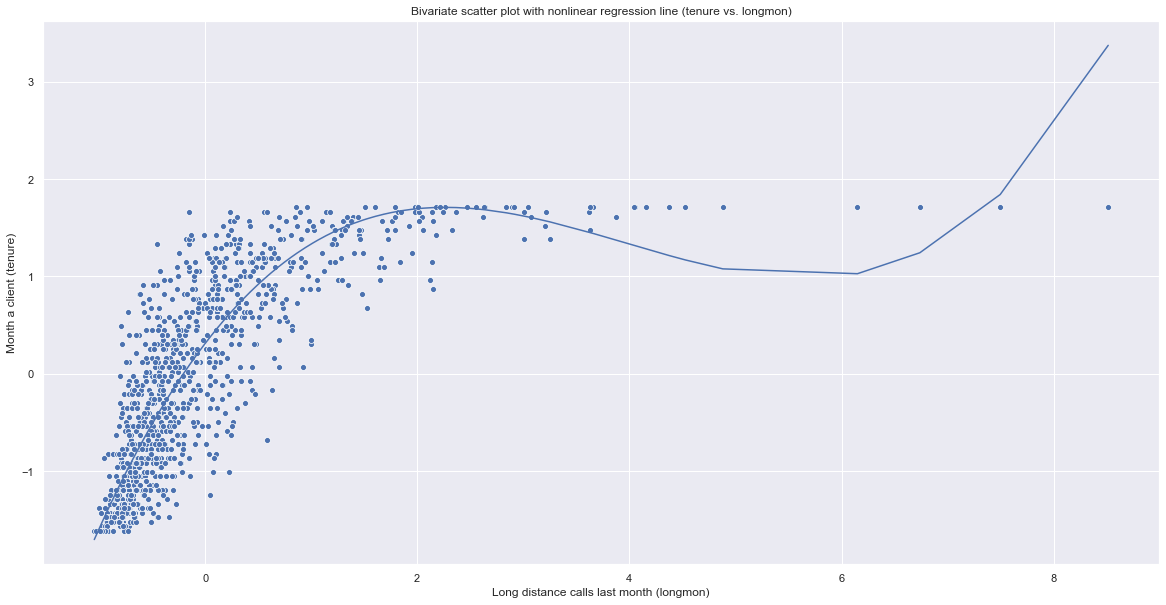

R2 score of nonlinear model: 0.71297
Root Mean Square Error (RMSE) of nonlinear model: 0.53548


In [78]:
from sklearn.svm import SVR

X = telco_df_norm_dummy.copy().longmon
X = X.to_numpy().reshape(-1, 1)
Y = telco_df_norm_dummy.copy().tenure

# print(X.reshape(-1).shape)

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
model.fit(X,Y)

plt.figure(figsize=(20,10))
sns.scatterplot(x=X.reshape(-1), y=telco_df_norm_dummy.tenure)
sns.lineplot(x=X.reshape(-1), y=model.predict(X))
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean())
print("R2 score of nonlinear model: %.5f" %model.score(X,Y))
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

To compare linear regression fit with nonlinear one numerically we could use Root Mean Square Error (RMSE) value of both models. I have calcualted it for each model by subtracting predicted value from real one, then square difference, calculate mean of all squared deviations and take square root from mean in the end. Since RMSE of linear model is 0.70012 and RMSE of nonlinear model is 0.53548 we could conclude that non-linear model fits given data better.

### Part (c)

Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.